In [1]:
import keras

from google.colab import drive
drive.mount('/content/gdrive')

Using TensorFlow backend.


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import pickle
from keras.utils import to_categorical 
from sklearn.model_selection import train_test_split 


path = '/content/gdrive/My Drive/Colab Notebooks/winter_school_2019/seismic_images/Lapteva_faults_10k.pickle'
with open(path, 'rb') as handle:
    data = pickle.load(handle)
    
X = data['X_set'] 
y = data['y_set'] 
X = X.reshape(X.shape + (1,))
y = y.reshape(y.shape + (1,))
print(X.shape, y.shape)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=.15, random_state=25)

y_train = to_categorical(y_train, num_classes=2) 
y_test = to_categorical(y_test, num_classes=2)
print(x_train.shape, y_train.shape)

(10240, 64, 64, 1) (10240, 64, 64, 1)
(8704, 64, 64, 1) (8704, 64, 64, 2)


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

from keras.layers import Input, Dense, Flatten, Reshape, Conv2D, BatchNormalization, Dropout, MaxPooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras import backend as K


def weighted_categorical_crossentropy(weights):
    weights = K.variable(weights)
    def loss(y_true, y_pred):
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    return loss


def create_model(
        depth=4,
        batch_norm=.3,
        dropout=.3,
        pooling=False,
        activation='relu',
        activation_out='sigmoid',
        lr=.001,
        weight_false=.2,
        weight_true=1,
):
    x = input_img = Input(shape=(64, 64, 1))

    filters = 16
    for i in range(depth):      
      x = Conv2D(filters, (3, 3), activation=activation, padding='same')(x)
      x = BatchNormalization()(x) if batch_norm else x
      x = Dropout(dropout)(x) if dropout else x
      x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x) if pooling else x
      
      filters = filters * 2 if filters < 64 else filters
        
    x = Flatten()(x)    
    x = Dense(100, activation=activation)(x)    
    x = Dropout(dropout)(x) if dropout else x
    x = Dense(64 * 64 * 2, activation=activation_out)(x)
    x = Reshape((64, 64, 2), input_shape=(64 * 64 * 2,))(x)
    
    model = Model(input_img, x, name="classification")
    loss = weighted_categorical_crossentropy(np.array([weight_false, weight_true]))
    model.compile(
        optimizer=Adam(lr=lr),
        loss=loss,
        metrics=['accuracy']
    )
    return model

model = create_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        160       
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 16)        64        
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
dropout_2 (Dropout)          (None, 64, 64, 32)        0         
__________

In [4]:
model.fit(
    x_train,
    y_train,
    epochs=200,
    batch_size=128,
    shuffle=True,
    validation_split=.3,
)

Train on 6092 samples, validate on 2612 samples
Epoch 1/200
6092/6092 [==============================] - 21s 4ms/step - loss: 0.0936 - acc: 0.9283 - val_loss: 0.0819 - val_acc: 0.9619
Epoch 2/200
6092/6092 [==============================] - 16s 3ms/step - loss: 0.0804 - acc: 0.9605 - val_loss: 0.0802 - val_acc: 0.9620
Epoch 3/200
6092/6092 [==============================] - 16s 3ms/step - loss: 0.0716 - acc: 0.9605 - val_loss: 0.0860 - val_acc: 0.9614
Epoch 4/200
6092/6092 [==============================] - 16s 3ms/step - loss: 0.0643 - acc: 0.9600 - val_loss: 0.0701 - val_acc: 0.9620
Epoch 5/200
6092/6092 [==============================] - 16s 3ms/step - loss: 0.0587 - acc: 0.9598 - val_loss: 0.0671 - val_acc: 0.9617
Epoch 6/200
6092/6092 [==============================] - 16s 3ms/step - loss: 0.0548 - acc: 0.9590 - val_loss: 0.0687 - val_acc: 0.9614
Epoch 7/200
6092/6092 [==============================] - 16s 3ms/step - loss: 0.0522 - acc: 0.9588 - val_loss: 0.0685 - val_acc: 0.9615


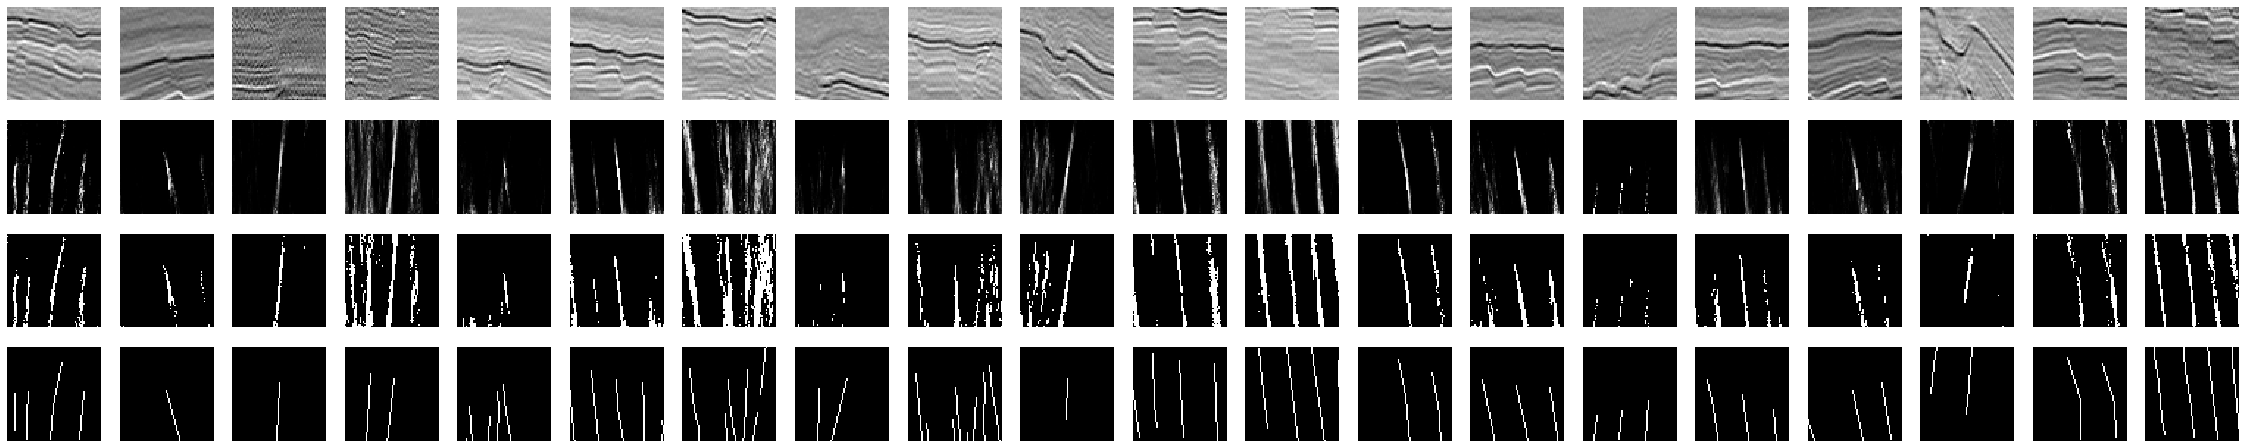

In [9]:
%matplotlib inline
def plot_digits(*args):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    
    plt.figure(figsize=(2 * n, 2 * len(args)))
    for j in range(n):
        for i, _ in enumerate(args):
        # for i in range(len(args)):
            ax = plt.subplot(len(args), n, i * n + j + 1)
            plt.imshow(args[i][j])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.show()

n = 20
trash = 0.2

answers = y_test[:n, :, :, 1:]
imgs = x_test[:n]
predicted = model.predict(imgs, batch_size=n)[:, :, :, 1:]
predicted_bool = predicted > trash

plot_digits(imgs, predicted, predicted_bool, answers)

(0.0, 1.0)

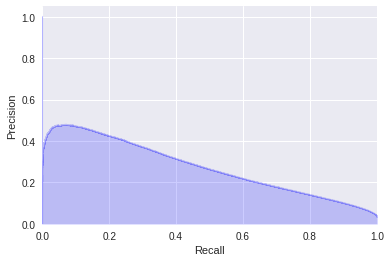

In [11]:
from sklearn.metrics import precision_recall_curve
from sklearn.utils.fixes import signature

y_score = model.predict(x_test, batch_size=n)[:, :, :, 1:]
y_label = y_test[:, :, :, 1:] > 0.5

y_score = y_score.reshape([y_score.size,])
y_label = y_label.reshape([y_label.size,])

precision, recall, _ = precision_recall_curve(y_label, y_score)

step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])